In [1]:
import datetime as dt
import pandas as pd
import  plotly.express as px 
import plotly.graph_objects as go

#Read US Covid deaths abd filter LA county 
US_Deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
US_Deaths_df = pd.read_csv(US_Deaths_url, error_bad_lines=True)
US_Deaths_df=US_Deaths_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df=US_Deaths_df.dropna(subset=['FIPS'])
US_Deaths_df=US_Deaths_df.melt(id_vars=["FIPS","Population","Province_State"], 
        var_name="Date", 
        value_name="Value")

#Read US Covid cases
Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['UID','iso2','iso3','code3','Admin2', 'Province_State', 'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.dropna(subset=['FIPS'])
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS'], 
        var_name="Date", 
        value_name="Value")


US_Deaths_df.iloc[:, 3] = pd.to_datetime(US_Deaths_df.iloc[:, 3])
US_Deaths_df.iloc[:, 3]  = (US_Deaths_df.iloc[:, 3]  - US_Deaths_df['Date'].iloc[0]).dt.days
US_Deaths_df = US_Deaths_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Deaths' })

#US_Deaths_df['Weekly_Deaths'] = US_Deaths_df.groupby(['FIPS', 'Week'])['Cumulative_Deaths'].transform(lambda x: (x.iat[-1] - x.iat[0]))
US_Deaths_df['Weekly_Deaths'] = 0
US_Deaths_df['Weekly_Deaths_Per'] = 0.0
US_Deaths_df['Past_Week_Cumulative_Deaths'] = 0
US_Deaths_df = US_Deaths_df.reset_index()
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Deaths_df['Cumulative_Deaths'].to_numpy()
fipsArray = US_Deaths_df['FIPS'].to_numpy()
i = 0
j = 0
FIPS = 0.0
for index, row in US_Deaths_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_deaths = cdArray[i-7]
        weekly_deaths = row['Cumulative_Deaths'] - previous_cum_deaths
        US_Deaths_df.at[index,'Weekly_Deaths'] =  weekly_deaths
        if previous_cum_deaths  == 0:
          previous_cum_deaths = 1
        US_Deaths_df.at[index, 'Past_Week_Cumulative_Deaths'] = previous_cum_deaths
        US_Deaths_df.at[index, 'Weekly_Deaths_Per'] = (weekly_deaths  * 100) / (previous_cum_deaths * 1.0)
  else:
    FIPS = countyFIPS
    j = 0 
    US_Deaths_df.at[index,'Weekly_Deaths'] = 0
  i = i + 1
  j = j + 1

US_Cases_df.iloc[:, 1] = pd.to_datetime(US_Cases_df.iloc[:, 1])
US_Cases_df.iloc[:, 1]  = (US_Cases_df.iloc[:, 1]  - US_Cases_df['Date'].iloc[0]).dt.days
US_Cases_df = US_Cases_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Cases'})
US_Cases_df['Weekly_Cases'] = 0
US_Cases_df['Weekly_Cases_Per'] = 0.0
US_Cases_df = US_Cases_df.reset_index()
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Cases_df['Cumulative_Cases'].to_numpy()
fipsArray = US_Cases_df['FIPS'].to_numpy()
i = 0
j = 0
for index, row in US_Cases_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_cases = cdArray[i-7]
        weekly_cases = row['Cumulative_Cases'] - previous_cum_cases
        US_Cases_df.at[index,'Weekly_Cases'] =  weekly_cases
        if previous_cum_cases  == 0:
          previous_cum_cases = 1
        US_Cases_df.at[index, 'Weekly_Cases_Per'] = (weekly_cases * 100.0) / (previous_cum_cases * 1.0)
  else:
    FIPS = countyFIPS
    j = 0
    US_Cases_df.at[index,'Weekly_Cases'] = 0
  i = i + 1
  j = j + 1
 

In [2]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [3]:
#load state tests data to combine with cases and deaths
#data is not available for all days, populate zero for missing ones
from datetime import timedelta, date

state_codes = pd.read_csv('https://docs.google.com/spreadsheets/d/1DAqxIYJdagFN85ncoTQO-CbpJLQECvZWt6qwNMQZUkk/export?format=csv')
start_date = date(2020, 1, 22)
end_date = date.today()

state_codes_date_df = pd.DataFrame({'Date': pd.Series([], dtype='str'),
                   'Code': pd.Series([], dtype='str'),
                   'State': pd.Series([], dtype='str')})
for single_date in daterange(start_date, end_date):
  for index, row in state_codes.iterrows():
    state_codes_date_df = state_codes_date_df.append({'Date': single_date.strftime("%Y%m%d"), 'Code' : row["Code"], 'State' : row["State"]}, ignore_index=True)
state_tests = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
convert_dict = {'date': str} 
state_tests = state_tests.astype(convert_dict)
state_tests_df = state_codes_date_df.merge(state_tests[['date','state','positive', 'negative']],how='left', left_on=['Date', 'Code'], right_on=['date', 'state'])
state_tests_df.sort_values(['Date','State'], inplace=True)
state_tests_df.iloc[:, 0] = pd.to_datetime(state_tests_df.iloc[:, 0],format="%Y%m%d")
state_tests_df.iloc[:, 0]  = (state_tests_df.iloc[:, 0] - state_tests_df['Date'].iloc[0]).dt.days
state_tests_df = state_tests_df.rename(columns={'Date': 'Days'})
state_tests_df['Cumulative_Tests'] = state_tests_df['positive'] + state_tests_df ['negative']
state_tests_df = state_tests_df.drop(columns=['date', 'state', 'positive', 'negative'])
state_tests_df.fillna(0, inplace=True)

In [4]:
#Read county variates dataset and combine with FIPS, race, icu_beds dataset
county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
#dropping full NaN counties
covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
#merge with US FIPS and makue  sure FIPS are only in the US
US_Deaths_df = US_Deaths_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
US_Cases_df = US_Cases_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
list(covariates.columns) 
covariates = covariates.dropna(axis='columns')
list(covariates.columns) 

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]
 
#print(covariates)

In [5]:
#build prior - 1 ,2 ,3 week(s) cases and deaths as features
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 7
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'One_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'One_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_df.merge(US_Cases_Prior_df[['One_Week_Prior_Weekly_Cases_Per', 'One_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 14
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'Two_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Two_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_df[['Two_Week_Prior_Weekly_Cases_Per', 'Two_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Cases_Prior_df = US_Cases_df.copy() 
US_Cases_Prior_df["Days"] = US_Cases_Prior_df["Days"] + 21
US_Cases_Prior_df.rename(columns = {'Weekly_Cases_Per':'Three_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Three_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_df[['Three_Week_Prior_Weekly_Cases_Per', 'Three_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])

US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 7
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'One_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'One_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['One_Week_Prior_Weekly_Deaths_Per', 'One_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 14
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'Two_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Two_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['Two_Week_Prior_Weekly_Deaths_Per', 'Two_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Prior_df = US_Deaths_df.copy()
US_Deaths_Prior_df["Days"] = US_Deaths_Prior_df["Days"] + 21
US_Deaths_Prior_df.rename(columns = {'Weekly_Deaths_Per':'Three_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Three_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_df[['Three_Week_Prior_Weekly_Deaths_Per', 'Three_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='inner', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])


In [6]:

US_Deaths_Cases_df = US_Deaths_Cases_df.merge(state_tests_df, how='inner', left_on=['Province_State', "Days"], right_on=['State', 'Days'])
covariates_merged = covariates.merge(US_Deaths_Cases_df[['Cumulative_Tests',
                                                        'Three_Week_Prior_Weekly_Cases_Per',
                                                        'Three_Week_Prior_Weekly_Cases',
                                                        'Two_Week_Prior_Weekly_Cases_Per',
                                                        'Two_Week_Prior_Weekly_Cases',
                                                        'One_Week_Prior_Weekly_Cases_Per',
                                                        'One_Week_Prior_Weekly_Cases',
                                                        'Three_Week_Prior_Weekly_Deaths_Per',
                                                        'Three_Week_Prior_Weekly_Deaths',
                                                        'Two_Week_Prior_Weekly_Deaths_Per',
                                                        'Two_Week_Prior_Weekly_Deaths',
                                                        'One_Week_Prior_Weekly_Deaths_Per',
                                                        'One_Week_Prior_Weekly_Deaths',
                                                         'FIPS', 'Days']], how='inner', left_on=["fips"], right_on=['FIPS'])
#dropping NaN columns
covariate_merged = covariates_merged.dropna(axis='columns')
US_Deaths_Cases_df =  US_Deaths_Cases_df.dropna(axis='columns')
fips_state=age_race_df[['STNAME','fips']]
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(fips_state, how='inner', left_on=["FIPS"], right_on=['fips'])
US_Deaths_Cases_df = US_Deaths_Cases_df.drop(columns=['index'])
#pd.set_option('display.max_rows', None)
#corr=covariate_merged.corr()
#print(corr[['Cumulative_Deaths','Daily_Deaths']])

In [19]:
US_Deaths_Cases_df[(US_Deaths_Cases_df['FIPS'] == 4015.0) & (US_Deaths_Cases_df['Days'] > 120)]

,fips,TOT_POP,0-9,0-9 y/o % of total pop,10-19,10-19 y/o % of total pop,20-29,20-29 y/o % of total pop,30-39,30-39 y/o % of total pop,40-49,40-49 y/o % of total pop,50-59,50-59 y/o % of total pop,60-69,60-69 y/o % of total pop,70-79,70-79 y/o % of total pop,80+,80+ y/o % of total pop,White-alone pop,% White-alone,Black-alone pop,% Black-alone,Native American/American Indian-alone pop,% NA/AI-alone,Asian-alone pop,% Asian-alone,Hawaiian/Pacific Islander-alone pop,% Hawaiian/PI-alone,Two or more races pop,% Two or more races,POP_ESTIMATE_2018,N_POP_CHG_2018,GQ_ESTIMATES_2018,R_birth_2018,R_death_2018,R_NATURAL_INC_2018,R_INTERNATIONAL_MIG_2018,R_DOMESTIC_MIG_2018,R_NET_MIG_2018,Less than a high school diploma 2014-18,High school diploma only 2014-18,Some college or associate's degree 2014-18,Bachelor's degree or higher 2014-18,Percent of adults with less than a high school diploma 2014-18,Percent of adults with a high school diploma only 2014-18,Percent of adults completing some college or associate's degree 2014-18,Percent of adults with a bachelor's degree or higher 2014-18,POVALL_2018,PCTPOVALL_2018,PCTPOV017_2018,PCTPOV517_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Jan Precipitation / inch,Feb Precipitation / inch,Mar Precipitation / inch,Apr Precipitation / inch,May Precipitation / inch,Jun Precipitation / inch,Jul Precipitation / inch,Jan Temp AVG / F,Feb Temp AVG / F,Mar Temp AVG / F,Apr Temp AVG / F,May Temp AVG / F,Jun Temp AVG / F,Jul Temp AVG / F,Active Physicians per 100000 Population 2018 (AAMC),Total Active Patient Care Physicians per 100000 Population 2018 (AAMC),Active Primary Care Physicians per 100000 Population 2018 (AAMC),Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC),Active General Surgeons per 100000 Population 2018 (AAMC),Active Patient Care General Surgeons per 100000 Population 2018 (AAMC),Total nurse practitioners (2019),Total physician assistants (2019),Total Hospitals (2019),Internal Medicine Primary Care (2019),Family Medicine/General Practice Primary Care (2019),Total Specialist Physicians (2019),ICU Beds_x,Total Population,Population Aged 60+,Percent of Population Aged 60+,Cumulative_Tests,Three_Week_Prior_Weekly_Cases_Per,Three_Week_Prior_Weekly_Cases,Two_Week_Prior_Weekly_Cases_Per,Two_Week_Prior_Weekly_Cases,One_Week_Prior_Weekly_Cases_Per,One_Week_Prior_Weekly_Cases,Three_Week_Prior_Weekly_Deaths_Per,Three_Week_Prior_Weekly_Deaths,Two_Week_Prior_Weekly_Deaths_Per,Two_Week_Prior_Weekly_Deaths,One_Week_Prior_Weekly_Deaths_Per,One_Week_Prior_Weekly_Deaths,FIPS,Days
55762,12086,2761581,310791,11.3,311496,11.3,365566,13.2,384271,13.9,394089,14.3,389885,14.1,290745,10.5,189981,6.9,124757,4.5,2177101,78.8,495637,17.9,7707,0.3,45768,1.7,1288,0.0,34080,1.2,2761581,16703.0,42228.0,11.4,7.9,3.4,21.3,-18.8,2.6,355875,533542,479454,553997,18.5,27.7,24.9,28.8,436103.0,16.0,22.6,21.9,52043.0,51208.0,52878.0,1383302.0,1330023.0,53279.0,3.9,52043.0,93.9,2.6,1.7,1.6,3.1,3.9,9.9,7.0,67.4,74.4,72.9,76.5,80.6,83.9,84.3,265.2,240.7,86.8,80.1,6.9,6.0,1602.5,790.0,28.1,1503.4,1073.6,3773.4,593.0,2702602,563748,20.9,1234550.0,12.0,1697,7.4,1177,6.4,1098,15.5,76,11.8,67,10.9,69,12086.0,138
55763,12086,2761581,310791,11.3,311496,11.3,365566,13.2,384271,13.9,394089,14.3,389885,14.1,290745,10.5,189981,6.9,124757,4.5,2177101,78.8,495637,17.9,7707,0.3,45768,1.7,1288,0.0,34080,1.2,2761581,16703.0,42228.0,11.4,7.9,3.4,21.3,-18.8,2.6,355875,533542,479454,553997,18.5,27.7,24.9,28.8,436103.0,16.0,22.6,21.9,52043.0,51208.0,52878.0,1383302.0,1330023.0,53279.0,3.9,52043.0,93.9,2.6,1.7,1.6,3.1,3.9,9.9,7.0,67.4,74.4,72.9,76.5,80.6,83.9,84.3,265.2,240.7,86.8,80.1,6.9,6.0,1602.5,790.0,28.1,1503.4,1073.6,3773.4,593.0,2702602,563748,20.9,1258305.0,10.8,1557,7.7,1226,6.2,1056,14.5,73,9.5,55,14.1,89,12086.0,139
55764,12086,2761581,310791,11.3,311496,11.3,36

In [27]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore", category=ConvergenceWarning)
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

min_day=US_Deaths_Cases_df['Days'].min()
max_day=US_Deaths_Cases_df['Days'].max()
countyFIPS = US_Deaths_Cases_df["FIPS"].unique()

num_weeks=int((max_day-min_day)/7)
print("number of weeks : " , num_weeks)
#prediction_days_arr = [7,14,21,28]
#prediction_days = 7   # one week  train , tune and forecast
#prediction_days = 14 # two weks train , tune and forecast
prediction_days = 14 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast
day_offset=61
best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Parameters", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths' 'Predicted_Cumulative_Deaths'])
#i = 0
#iteration = 0 
index = 0
#tune_forecast_rscores = pd.DataFrame( columns=['week', 'tune_alpha', 'tune_max_r2_score', 'forecast_r2_score'])
#weekly_alpha_rscores = pd.DataFrame( columns=['week', 'alpha', 'r2_score'])
#predict_week_rscores = pd.DataFrame( columns=['week', 'r2_score'])

train_start_week_day = day_offset
train_end_week_day = train_start_week_day + prediction_days
tune_start_week_day = train_end_week_day
tune_end_week_day = train_end_week_day + prediction_days
predict_start_week_day = train_end_week_day 
predict_end_week_day = predict_start_week_day + 14
xgb = xgb.XGBRegressor()
  

for week_num in range(num_weeks):
    if train_end_week_day > max_day:
        break
    predict_start_date = (covid_start_date + timedelta(days=predict_start_week_day)).date()
    predict_end_date =  (covid_start_date + timedelta(days=predict_end_week_day)).date()
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,
        " predict start date: ",  predict_start_date,
        " predict end date: ",  predict_end_date)
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['Days'].isin(train_week))] 
    US_Weekly_Deaths = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(train_week))].iloc[:, 5]  
    if len(US_Weekly_Deaths) == 0:
        continue
    alphas = [.0001,0.001, 0.01, 0.1]

    #train and predict the future week for LA County
    tune_week = pd.Series(range(tune_start_week_day, tune_end_week_day ))
    #print ("tune next week series :" , tune_week.array)

    alpha_with_max_r2score = -1
    max_r2score = -10
    best_reg = None

    X_train = covariates_train_week
    Y_train = US_Weekly_Deaths
    #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
    parameters = {
          'objective':['reg:squarederror'],
          'learning_rate': [0.01, 0.04,0.08, 0.1], #so called `eta` value
          'max_depth': [3,4,5],
          'min_child_weight': [1,2,4,8,16],
          'subsample': [0.8],
          'colsample_bytree' : [0.8],
          'n_estimators': [50,100,200]}
    xgb_grid = GridSearchCV(xgb,
                    parameters,
                    cv = 2,
                    n_jobs = 5,
                    scoring = 'r2',
                    verbose=True)

    xgb_grid.fit(X_train,Y_train)


    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)

    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    #print ("predicting next week series :" , predict_week.array)
  
    X_predict_week = covariates_merged.loc[(covariates_merged['Days'].isin(predict_week))]
    predict_week_df = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(predict_week))]
    Y_actual_predict_week = predict_week_df.iloc[:,5]
    #best_reg.fit(X_tune_week, Y_actual_tune_week)
    Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
    predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
    print(week_num , ":", predict_score)
  
    predicted_df = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths','Predicted_Cumulative_Deaths'])
    predicted_df["State"] = predict_week_df["STNAME"]
    predicted_df["FIPS"] = predict_week_df["FIPS"]
    predicted_df["Days"] = predict_week_df["Days"]
    predicted_df["Forecast_Day"] =  (covid_start_date + timedelta(days=(predict_start_week_day-1))).strftime("%Y-%m-%d")
    predicted_df["Predicted_Weekly_Deaths"] = Y_predict_week
    predicted_df["Predicted_Cumulative_Deaths"] = predicted_df["Predicted_Weekly_Deaths"]  + predict_week_df["Past_Week_Cumulative_Deaths"]
    best_fit_scores.loc[index] = [str(predict_start_date) + ' - '  + str(predict_end_date), xgb_grid.best_params_, xgb_grid.best_score_,  predict_score]
    
    pwcdArray = predicted_df["Predicted_Cumulative_Deaths"].to_numpy()
    fipsArray = predicted_df['FIPS'].to_numpy()
    j = 0
    i = 0 
    FIPS = 0.0
    for index, row in predicted_df.iterrows():
        countyFIPS = row['FIPS']
        if  FIPS == countyFIPS:
            if (j > 6) and  fipsArray[i-7] == countyFIPS:
                past_week_cum_deaths = pwcdArray[i-7]
                predicted_df.at[index, 'Predicted_Cumulative_Deaths'] = row["Predicted_Weekly_Deaths"] + past_week_cum_deaths
        else:
            FIPS = row['FIPS']
            j = 0 
        i = i + 1
        j = j + 1
        

    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    train_start_week_day = train_start_week_day + 7
    train_end_week_day = train_end_week_day + 7
    predict_start_week_day = train_end_week_day
    predict_end_week_day = train_end_week_day + 14
    index = index + 1

number of weeks :  22
train: 61 : 75  predict: 75 : 89  predict start date:  2020-04-06  predict end date:  2020-04-20
Fitting 2 folds for each of 180 candidates, totalling 360 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   53.0s


KeyboardInterrupt: 

In [21]:
best_fit_scores[["Best_Score", "Predict_R2_Score"]] = best_fit_scores[["Best_Score", "Predict_R2_Score"]].apply(pd.to_numeric)
best_fit_scores.to_csv('scores.csv', index=False)

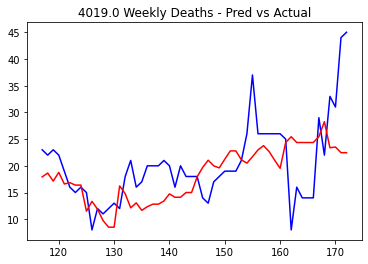

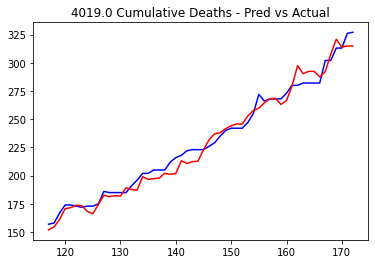

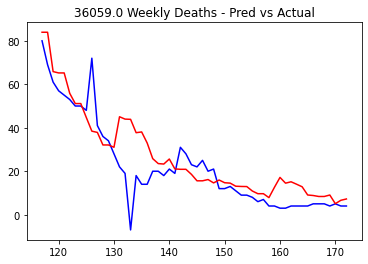

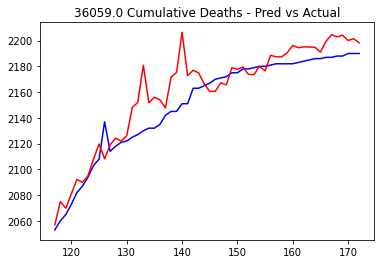

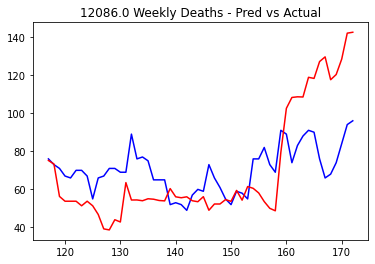

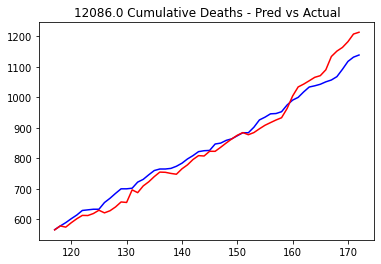

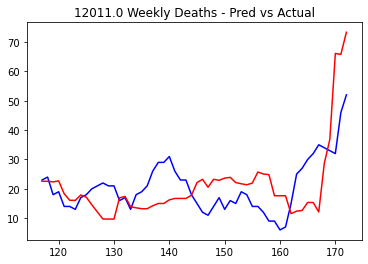

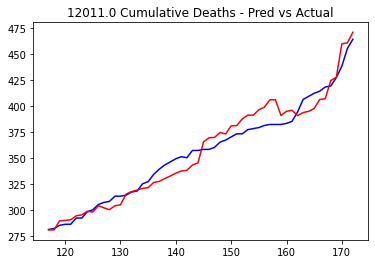

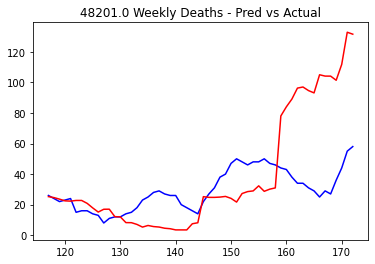

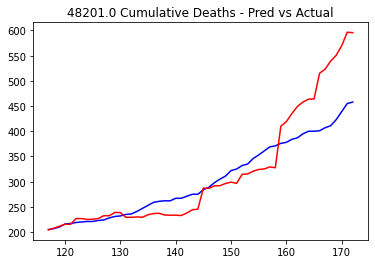

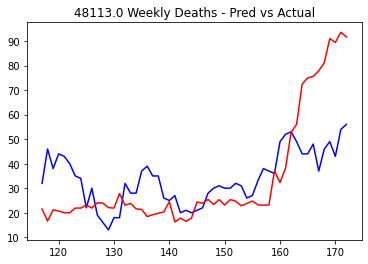

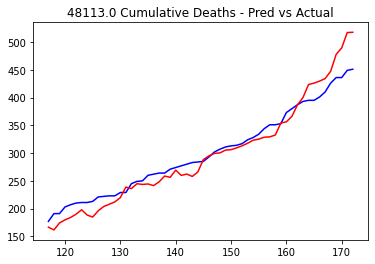

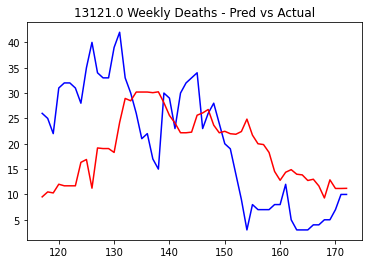

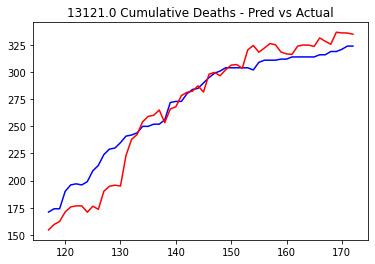

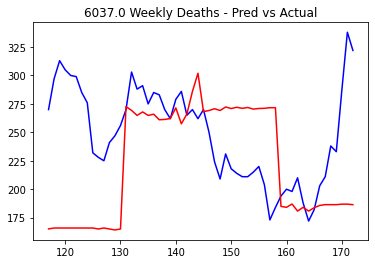

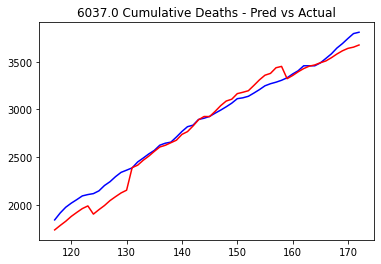

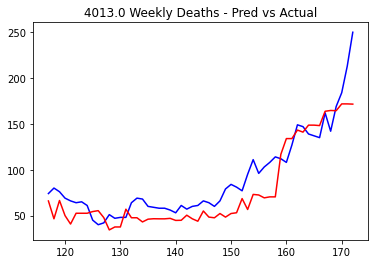

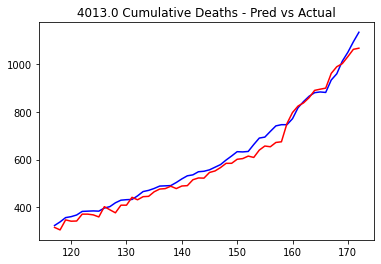

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
FIPS = [ 4019.0,36059.0, 12086.0, 12011.0, 48201.0,48113.0,13121.0,6037.0,  4013.0]
forecast_days = ['2020-05-17', '2020-05-31', '2020-06-14','2020-06-28','2020-07-12']

for f in FIPS:
        
    predicted_df_90 = predicted_df_all_days[(predicted_df_all_days["FIPS"] == f) & (predicted_df_all_days["Forecast_Day"].isin(forecast_days))]

    Deaths_Cases_df = US_Deaths_Cases_df[(US_Deaths_Cases_df["FIPS"] == f) &  (US_Deaths_Cases_df["Days"] >= 117) &(US_Deaths_Cases_df["Days"] <= 172)]

    x = Deaths_Cases_df["Days"]
    z= predicted_df_90["Predicted_Weekly_Deaths"]
    y = Deaths_Cases_df["Weekly_Deaths"]
    plt.title(str(f) +" Weekly Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
    plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_Weekly_Deaths.png", dpi=100)   
    plt.show()

    x = Deaths_Cases_df["Days"]
    z= predicted_df_90["Predicted_Cumulative_Deaths"]
    y = Deaths_Cases_df["Cumulative_Deaths"]
    plt.title(str(f) +" Cumulative Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
    plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_X_Cumulative_Deaths.png", dpi=100)
    plt.show()


In [12]:
from datetime import datetime

covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

state_predicted_deaths = predicted_df_all_days.groupby(['State', 'Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()
state_to_fips=pd.read_csv('https://docs.google.com/spreadsheets/d/1w4sHgYifJV-C8J1WV5rpTzEFLuyZ5ESp8r_1ck-9hlA/export?format=csv')
state_predicted_deaths = state_predicted_deaths.merge(state_to_fips, how='left', left_on=['State'], right_on=['Name'])
state_predicted_deaths=state_predicted_deaths.drop(columns=['Name'])
country_predicted_deaths = predicted_df_all_days.groupby(['Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()

state_predicted_deaths=state_predicted_deaths[['State','FIPS','Days','Forecast_Day','Predicted_Cumulative_Deaths']]
iteration = 0  
forecast_dates = country_predicted_deaths["Forecast_Day"].unique()
for forecast_date in forecast_dates:
  print(forecast_date)  
  covid_hub_predicted_deaths = pd.DataFrame(columns=['forecast_date','target', 'target_end_date','location', 'location_name','type', 'quantile', 'value']) 
  filename = "forecast-hub/data-processed/MIT_Sak/{}-MIT-Sak.csv".format(forecast_date)
  cp_detahs_forecast= country_predicted_deaths[country_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in cp_detahs_forecast.iterrows():

      covid_hub_predicted_deaths.loc[iteration,"location"] = 'US'
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = 'US'
      #predicted_df["FIPS"] = predict_week_df["FIPS"]
      #predicted_df["Days"] = predict_week_df["Days"]
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0

      iteration = iteration + 1
  state_predicted_deaths_forecast = state_predicted_deaths[state_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in state_predicted_deaths_forecast.iterrows():
      covid_hub_predicted_deaths.loc[iteration,"location"] = str(row["FIPS"]).zfill(2)
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = row["State"]
   
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
   
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0
      iteration = iteration + 1
  
  covid_hub_predicted_deaths.to_csv(filename,index = False)
  #files.download(filename)


2020-04-12
2020-04-19
2020-04-26
2020-05-03
2020-05-10
2020-05-17
2020-05-24
2020-05-31
2020-06-07
2020-06-14
2020-06-21
2020-06-28
2020-07-05
2020-07-12


In [13]:
import evaluate_models
from datetime import datetime, timedelta
from os import listdir
from os.path import isfile, join
files = listdir('forecast-hub/data-processed/MIT_Sak')
files.sort()
for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=5) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/one-week")


running evaluation for proj_date:  2020-03-30  eval_date:  2020-04-04
Forecast hub dir: forecast-hub
proj_date: 2020-03-30
eval_date: 2020-04-04
out_dir   : eval/one-week
use_point: True
use_cumulative_deaths: False
Days ahead: 5
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv']
CDDEP-SEIR - No files within range: ['2020-07-05-CDDEP-SEIR.csv']
COVIDhub-baseline - No files within range: ['2020-04-06-COVIDhub-baseline.csv', '2020-04-13-COVIDhub-baseline.csv', '2020-04-20-COVIDhub-baseline.csv', '2020-04-27-COVIDhub-baseline.csv', '2020-05-04-COVIDhub-baseline.csv', '2020-05-11-COVIDhub-baseline.csv', '2020-05-18-COVIDhub-baseline.csv', '2020-05-25-COVIDhub-baseline.csv', '2020-06-01-COVIDhub-baseline.csv', '2020-06-08

US                          11031.0    6022.6         5900.6         7873.3             10401.0             10701.0  25465.8
Saved to: eval/one-week/2020-04-04/projections_2020-03-30_2020-04-04.csv
------------------------
State-by-state mean absolute errors:
               Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline         -25.4    -1.3    -22.1      -2.9       -84.4     -43.9       -108.7      -2.9                 -13.4   -102.1    -73.9    -3.0   -0.7    -129.1    -61.7  -6.6    -9.7     -25.9   
Baseline_0.98    -25.8    -1.4    -22.8      -3.1       -88.4     -45.6       -109.8      -3.1                 -13.6   -103.9    -76.2    -3.0   -0.9    -131.5    -62.8  -6.7    -9.9     -26.1   
IHME-CurveFit     -2.5     1.9      0.4       9.9        31.4       9.4        -88.6      -0.1                   7.2    -48.2    -14.9    -1.9    4.0   

Max projection date: 2020-05-30 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 17.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-11 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-11 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
LANL-GrowthRate
Max projection date: 2020-05-23 - 6.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 51
-----------------------------
MIT_Sak
Max projection date: 2020-04-19 - 1.9 weeks ahead
* No median data
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 

Saved to: eval/one-week/2020-04-11/projections_2020-04-06_2020-04-11.csv
------------------------
State-by-state mean absolute errors:
                   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline             -17.0     1.4    -12.7      -0.4       -64.0     -54.3       -172.1     -12.1                 -10.4    -75.6   -105.7    -0.6  -10.7    -224.7   -121.6  -4.0   -20.1     -14.1   
Baseline_0.98        -18.5     1.3    -14.7      -0.8       -73.3     -58.2       -178.6     -12.5                 -11.1    -82.5   -111.2    -0.7  -10.9    -233.4   -125.5  -4.6   -20.8     -15.6   
COVIDhub-baseline     -8.0     0.0    -28.0      -2.0      -136.0     -83.0       -197.0     -10.0                  -9.0   -102.0    -96.0    -2.0   -9.0    -236.0   -129.0  -9.0   -17.0     -19.0   
IHME-CurveFit        106.9    97.5     -4.8      19.6        55.5

Max projection date: 2020-06-06 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 16.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-18 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1


----------------------------------
Past truth file: /Users/snathikudi/work/covid-forecaster/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 12846
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-13 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-30 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 15.1 weeks ahead
* No median

                      count  mean  median   std  min  25%   75%    max
Baseline_0.98          51.0  53.7    14.5 121.6  0.2  4.6  47.2  785.2
Baseline               51.0  55.6    12.6 147.5  0.1  4.2  40.9  999.7
IHME-CurveFit          51.0  61.7    16.8 145.5  0.0  6.8  47.9  974.2
YYG-ParamSearch        51.0  63.9    15.6 136.6  0.2  4.0  55.1  768.8
LANL-GrowthRate        51.0  91.3    16.7 280.3  0.7  7.4  51.6 1927.6
MIT_Sak                51.0 118.6    57.8 160.2  0.0 26.6 121.8  748.2
COVIDhub-baseline      51.0 134.1    10.0 663.1  0.0  5.0  35.0 4727.0
CU-select              51.0 169.5    34.0 444.6  1.0 10.5 109.5 2771.0
UT-Mobility            51.0 172.2    17.7 809.7  0.9  4.4  51.6 5777.3
MOBS_NEU-GLEAM_COVID   51.0 215.3    49.4 399.7  2.6 17.6 188.9 1959.8
Saved to: eval/one-week/2020-04-25/2020-04-20_2020-04-25_states_abs_errs.csv
----------------------
Mean/median ranks:
COVIDhub-baseline      3.2
UT-Mobility            3.5
YYG-ParamSearch        3.6
IHME-CurveFit      

Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-02 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 14.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 53
Num unique locations (

Saved to: eval/one-week/2020-05-02/projections_2020-04-27_2020-05-02.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                     -15.9     0.0     23.0     -10.7        14.7      85.7        171.1      -2.6                   8.3    -31.0    -64.7     1.4    2.3     -74.9    -86.9 -20.1     3.0   
Baseline_0.98                -18.4     0.0     19.2     -11.2        -8.2      74.5        137.9      -4.8                   4.9    -43.6    -74.3     1.3    1.8    -101.7    -97.3 -21.9     1.8   
COVIDhub-baseline            -23.0     0.0     36.0     -14.0        58.0     147.0        208.0     -11.0                  -1.0     -2.0    -36.0     1.0    5.0     -68.0    -88.0 -25.0    13.0   
COVIDhub-ensemble             -0.9     2.9     34.1       2.2        52.1

Max projection date: 2020-06-27 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-30 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-select
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
GT-DeepCOVID
Max projection date: 2020-05-18 - 2.0 weeks ahead
Num unique locations (pre-filt) : 48
Num unique locations (post-filt): 48
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-09 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-24 - 16.0 weeks ahead
* No median data
Num unique locations (pre-

GT-DeepCOVID                51.0 1458185.0  3853.3 9692997.9  0.0 272.3 35510.4 69291529.8
Saved to: eval/one-week/2020-05-09/2020-05-04_2020-05-09_states_sq_errs.csv
----------------------
States - mean absolute errors:
                           count  mean  median    std  min  25%   75%    max
Baseline_0.98               51.0  38.2    12.6   68.6  0.0  3.5  34.4  331.2
Baseline                    51.0  39.8    11.4   73.9  0.0  4.9  35.4  411.9
COVIDhub-ensemble           51.0  40.4    12.8   94.2  0.9  4.5  26.7  548.1
YYG-ParamSearch             51.0  42.2    16.7   75.5  0.2  4.8  42.0  475.9
COVIDhub-baseline           51.0  45.2    12.0   89.7  0.0  4.0  39.5  454.0
LANL-GrowthRate             51.0  51.0    12.3  104.7  0.0  5.4  67.1  677.1
MOBS_NEU-GLEAM_COVID        51.0  71.7    25.0  127.0  1.0  6.1  73.8  771.2
UMass-MechBayes             51.0  77.5    28.0  181.9  0.0  8.0  54.0 1167.0
CU-select                   51.0  78.0    35.0  186.2  0.0  7.0  57.5 1122.0
IHME-Curv

Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-08 - 4.0 weeks ahead
Num unique locations (pre-filt) : 28
Num unique locations (post-filt): 22
--------------------------

Saved to: eval/one-week/2020-05-16/projections_2020-05-11_2020-05-16.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                      -3.7     0.9      6.1       5.9       -63.4    -110.4         83.1     -27.3                   9.7     50.1     -1.7     0.0   -3.4     -47.6     89.3 -11.6     4.7   
Baseline_0.98                 -8.0     0.8     -1.1       5.2       -84.3    -115.8         61.0     -29.1                   6.7     35.9    -11.0     0.0   -3.6     -80.5     73.6 -15.0     3.5   
COVIDhub-baseline              7.0     1.0     55.0       6.0       -14.0     -90.0         89.0     -12.0                   7.0    102.0     31.0     1.0   -3.0      10.0    124.0 -17.0    11.0   
COVIDhub-ensemble            -14.9     1.7    -34.5       7.4       -44.0

Max projection date: 2020-07-11 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-13 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 26
Num unique locations (post-filt): 26
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-23 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Ma

Saved to: eval/one-week/2020-05-23/projections_2020-05-18_2020-05-23.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  110.0     2.0     43.0      24.0       283.0     120.0         62.0      44.0                  41.0    164.0     97.0     4.0   13.0     602.0    214.0  48.0    56.0   
Baseline                      20.4     0.0      2.4     -11.0       -47.9      97.1        111.0      27.1                   7.4    -44.0    -37.1     0.0   -0.9      47.9     -4.7 -21.3     8.0   
Baseline_0.98                 16.5     0.0     -3.6     -11.3       -69.7      87.0         92.6      24.3                   4.9    -54.5    -45.7     0.0   -1.1      15.7    -14.9 -24.9     7.1   
COVIDhub-baseline             31.0     0.0     25.0      -7.0        -8.0

Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-10 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 38
Num unique locations (post-filt): 31
-----------------------------
Geneva-DetGrowth
Max proje

Saved to: eval/one-week/2020-05-30/projections_2020-05-25_2020-05-30.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Auquan-SEIR                  185.0     5.0    102.0      37.0       607.0     230.0        154.0      81.0                  78.0    325.0    170.0     8.0   24.0    1100.0    383.0   94.0    95.0   
Baseline                     -13.0     0.0      0.7      -1.6        49.6     -10.7         25.3      -4.1                  12.0     16.3      9.0     0.0    2.1     108.0     43.9   15.0    -1.4   
Baseline_0.98                -15.6     0.0     -4.3      -2.3        28.1     -15.6         13.4      -5.6                  10.0      5.3     -0.1     0.0    1.9      79.7     34.5   10.6    -1.8   
COVIDhub-baseline             -5.0     0.0     19.0      -1.0       1

----------------------------------
Past truth file: /Users/snathikudi/work/covid-forecaster/truth/truth-cumulative-deaths-2020-06-01.csv
Incident US deaths: 5454
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-25 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-29 - 4.0 weeks ahead
Num unique locations (pre-fil

Saved to: eval/one-week/2020-06-06/projections_2020-06-01_2020-06-06.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  124.0     5.0    125.0      47.0       682.0     331.0        419.0      95.0                  99.0    313.0    270.0     8.0   33.0    1086.0    267.0 139.0    94.0   
Baseline                       8.7     0.0    -45.1      -6.4       -75.9      14.9        104.1      10.3                  12.1    -53.6     68.7     0.0    1.6     -16.3    -22.6   3.7    -9.4   
Baseline_0.98                  5.4     0.0    -49.6      -7.1       -93.3      10.1         93.7       8.6                  10.7    -62.5     59.3     0.0    1.4     -38.6    -29.2   0.4    -9.8   
COVIDhub-baseline             -2.0     0.0    -36.0      -3.0       -56.0

Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-24 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max proj

Saved to: eval/one-week/2020-06-13/projections_2020-06-08_2020-06-13.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  133.0     2.0    193.0      70.0       839.0     231.0        344.0      73.0                  60.0    697.0    355.0     5.0   20.0    1028.0    290.0 305.0    71.0   
Baseline                     -27.9    -2.0    -14.6      -5.0       -49.7       0.3         -6.1       6.4                  -2.3    -11.6   -158.1     0.0   -3.1      55.6     34.9  15.0     3.4   
Baseline_0.98                -30.4    -2.0    -20.6      -5.9       -68.9      -3.1        -11.4       5.1                  -3.2    -22.0   -163.4     0.0   -3.2      34.1     27.8  12.1     2.7   
COVIDhub-baseline            -13.0    -2.0     -7.0      -2.0        -8.0

Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-08 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-13 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-31 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max proj

US                                  121335.0  
Saved to: eval/one-week/2020-06-20/projections_2020-06-15_2020-06-20.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  221.0     5.0    442.0      90.0      1105.0     203.0        316.0      81.0                  69.0    713.0    397.0     5.0   25.0    1395.0    444.0 180.0    79.0   
Baseline                       4.4     1.7    -35.0     -23.6         5.3      11.9         61.4       8.6                   6.3    -15.0     41.3     0.0    1.4      29.3    -12.0  11.3    -0.7   
Baseline_0.98                  1.0     1.6    -40.8     -24.6       -14.2       8.9         56.0       7.6                   5.2    -24.6     30.0     0.0    1.3      12.4    -17.0   9.3    -1.2   
COVIDhub-baseline         

                           count  mean  median   std  min  25%   75%    max
YYG-ParamSearch             51.0  12.8     6.2  16.8  0.2  1.6  17.6   79.5
UMass-MechBayes             51.0  13.3     7.0  17.3  0.0  2.0  18.5   70.0
UCLA-SuEIR                  51.0  15.7     8.1  20.0  0.1  2.7  20.6   88.7
OliverWyman-Navigator       51.0  17.0     8.5  20.6  0.0  2.6  24.5   90.0
Baseline_0.98               51.0  17.9     6.2  29.1  0.0  1.2  21.2  132.8
Baseline                    51.0  19.8     5.3  32.5  0.0  1.9  23.4  151.6
COVIDhub-ensemble           51.0  20.3     9.5  23.2  0.1  2.4  29.3   93.8
MOBS_NEU-GLEAM_COVID        51.0  23.1     9.1  28.2  0.1  2.8  38.6  106.9
UA-EpiCovDA                 51.0  24.9    10.0  29.2  0.0  3.0  44.5  114.0
UT-Mobility                 51.0  27.6     9.0  55.0  0.0  2.5  29.0  313.0
COVIDhub-baseline           51.0  28.1    11.0  47.8  0.0  2.0  32.0  250.0
LANL-GrowthRate             51.0  28.6    12.9  40.1  0.3  2.6  35.5  213.7
PSI-DRAFT   

Max projection date: 2020-08-15 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-20 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-07 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 43
Num unique locations (post-filt): 43
------

Saved to: eval/one-week/2020-06-27/projections_2020-06-22_2020-06-27.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                   -7.0    -1.0     15.0       7.0       188.0      34.0         44.0     -51.0                   4.0     84.0    176.0     0.0    6.0     178.0     36.0  33.0    13.0   
Baseline                     -23.4    -2.0    -95.6       5.4       -27.4      15.0         -0.4     -60.9                   0.4    -31.9     31.6    -1.0   -0.3      64.6     25.1  11.1    -0.7   
Baseline_0.98                -26.2    -2.0   -102.2       3.5       -44.8      13.0         -2.9     -61.4                  -0.3    -41.5     23.6    -1.0   -0.4      50.4     20.2   9.7    -1.2   
COVIDhub-baseline            -16.0    -2.0    -77.0      12.0        13.0

Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-22 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-27 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-14 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection d

                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  GT-DeepCOVID  GT_CHHS-COVID19  IHME-CurveFit  \
Alabama                      1007.0     987.6          984.2        998.0             1000.0             1001.2     1177.0                1000.4         970.2              nan         1010.8   
Alaska                         16.0      15.7           15.6         15.0               16.0               14.7       14.0                  14.1          15.5              nan           12.1   
Arizona                      1817.0    1804.0         1793.8       1867.0             1814.0             1835.5     2092.0                1929.3        1804.2              nan         1837.3   
Arkansas                      286.0     297.4          295.8        325.0              294.0              309.3      391.0                 257.0         300.3              nan          313.6   
California                   6

Incident US deaths: 4817
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CDDEP-SEIR
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 24
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-01 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date:

                           count      mean  median       std  min   25%     75%        max
COVIDhub-ensemble           51.0    2835.7   115.1    9579.2  0.1   6.5   636.4    58686.2
USC-SI_kJalpha              51.0    3486.0   109.9   13083.5  0.0   7.8   780.9    83220.1
UMass-MechBayes             51.0    4190.9   121.0   13528.3  0.0   4.0   485.0    65025.0
OliverWyman-Navigator       51.0    4257.5    68.0   14703.5  0.1   8.7   392.0    72714.4
USACE-ERDC_SEIR             51.0    4395.2   104.8   12812.8  0.0  24.1  1252.7    64483.5
UCLA-SuEIR                  51.0    4855.2   139.0   16628.6  0.0  36.4  1310.3    92367.5
LANL-GrowthRate             51.0    4998.0    89.0   23003.6  0.0   4.5   567.0   162226.5
UT-Mobility                 51.0    5010.5   121.0   13400.3  0.0  16.0  2682.5    65025.0
COVIDhub-baseline           51.0    5331.5    81.0   16967.1  0.0  17.0   962.0    89401.0
MOBS_NEU-GLEAM_COVID        51.0    5604.6   314.9   15530.5  0.0  21.0  1859.0    73123.6

KeyError: 'US'

In [14]:

for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=12) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/two-weeks")

running evaluation for proj_date:  2020-03-30  eval_date:  2020-04-11
Forecast hub dir: forecast-hub
proj_date: 2020-03-30
eval_date: 2020-04-11
out_dir   : eval/two-weeks
use_point: True
use_cumulative_deaths: False
Days ahead: 12
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv']
CDDEP-SEIR - No files within range: ['2020-07-05-CDDEP-SEIR.csv']
COVIDhub-baseline - No files within range: ['2020-04-06-COVIDhub-baseline.csv', '2020-04-13-COVIDhub-baseline.csv', '2020-04-20-COVIDhub-baseline.csv', '2020-04-27-COVIDhub-baseline.csv', '2020-05-04-COVIDhub-baseline.csv', '2020-05-11-COVIDhub-baseline.csv', '2020-05-18-COVIDhub-baseline.csv', '2020-05-25-COVIDhub-baseline.csv', '2020-06-01-COVIDhub-baseline.csv', '2020-06-

               count      mean  median       std  min   25%     75%        max
IHME-CurveFit   51.0  317168.1  2017.9 2043538.3  0.9 161.1  9512.6 14577353.1
Baseline        51.0 1228034.6  3951.0 7943291.9  0.0 188.3 31758.5 56748241.3
Baseline_0.98   51.0 1341589.0  4290.5 8716868.8  0.0 196.8 33122.1 62280139.0
Saved to: eval/two-weeks/2020-04-11/2020-03-30_2020-04-11_states_sq_errs.csv
----------------------
States - mean absolute errors:
               count  mean  median    std  min  25%   75%    max
IHME-CurveFit   51.0 155.3    44.9  546.7  0.9 12.7  97.1 3818.0
Baseline        51.0 309.1    62.9 1074.8  0.0 13.7 178.1 7533.1
Baseline_0.98   51.0 320.8    65.5 1124.0  0.0 14.0 182.0 7891.8
Saved to: eval/two-weeks/2020-04-11/2020-03-30_2020-04-11_states_abs_errs.csv
----------------------
Mean/median ranks:
IHME-CurveFit   1.0
Name: mean_rank, dtype: float64
Saved to: eval/two-weeks/2020-04-11/2020-03-30_2020-04-11_states_mean_ranks.csv
running evaluation for proj_date:  2020-0

Max projection date: 2020-05-30 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 17.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-11 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-11 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
LANL-GrowthRate
Max projection date: 2020-05-23 - 6.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 51
-----------------------------
MIT_Sak
Max proj

------------------------
State-by-state mean absolute errors:
                   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline             -43.0     4.4    -28.7      -3.4      -376.0     -98.3       -609.1     -38.1                 -37.4   -220.6   -218.7     2.4  -23.7    -598.7   -241.6 -30.0   -35.1     -32.1   
Baseline_0.98        -50.3     3.6    -38.5      -5.5      -422.4    -117.6       -641.3     -39.8                 -41.0   -254.8   -245.9     1.6  -24.8    -641.8   -261.3 -32.9   -38.3     -39.6   
COVIDhub-baseline    -29.0     2.0    -54.0      -6.0      -493.0    -140.0       -657.0     -35.0                 -36.0   -271.0   -208.0     0.0  -21.0    -621.0   -259.0 -38.0   -30.0     -42.0   
IHME-CurveFit        289.4   182.3     31.4      57.1       -36.8    -149.5        553.7     -20.7                 -47.6   1196.9    704.3

Max projection date: 2020-06-06 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 16.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-18 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num

Max projection date: 2020-06-13 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-30 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 15.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No point

                      count  mean  median    std  min  25%   75%     max
YYG-ParamSearch        51.0 118.8    31.8  206.2  0.6  6.0 126.0  1148.3
Baseline_0.98          51.0 127.3    31.5  342.2  0.6 11.5 106.0  2374.2
Baseline               51.0 131.2    19.7  482.1  1.3 11.1  81.6  3439.7
IHME-CurveFit          51.0 166.7    41.5  301.8  0.9  9.9 154.9  1653.4
LANL-GrowthRate        51.0 194.8    39.2  688.6  0.5 10.2 107.2  4841.3
CU-select              51.0 218.3    73.0  368.4  1.0 14.5 189.0  1896.0
MIT_Sak                51.0 218.7   103.3  310.3  1.2 44.3 192.5  1458.7
UT-Mobility            51.0 291.8    31.4 1092.3  0.4 12.2 162.8  7593.0
COVIDhub-baseline      51.0 297.2    19.0 1547.9  1.0  9.0  97.0 11071.0
MOBS_NEU-GLEAM_COVID   51.0 337.6    93.6  669.8  0.9 37.5 254.9  3380.9
Saved to: eval/two-weeks/2020-05-02/2020-04-20_2020-05-02_states_abs_errs.csv
----------------------
Mean/median ranks:
COVIDhub-baseline      3.3
YYG-ParamSearch        3.4
UT-Mobility            

Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-02 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 14.1 weeks ahead
* No median data
Num unique 

Saved to: eval/two-weeks/2020-05-09/projections_2020-04-27_2020-05-09.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                     -55.9    -1.0    -88.0     -14.7        55.7     218.7        472.1      -2.6                  19.3    -81.0    -61.7     4.4   11.3    -221.9   -210.9 -54.1    -1.0   
Baseline_0.98                -68.7    -1.0   -106.9     -17.2       -57.9     163.2        306.9     -13.6                   2.3   -143.4   -109.2     3.6    8.8    -355.2   -262.9 -63.1    -6.8   
COVIDhub-baseline            -69.0    -0.8    -73.0     -20.0       100.0     307.0        491.0     -19.0                   2.0    -46.0    -28.0     4.0   15.0    -242.0   -222.0 -64.0    16.0   
COVIDhub-ensemble            -34.8     3.2    -71.9       9.3       141.

Max projection date: 2020-06-27 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-30 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-select
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
GT-DeepCOVID
Max projection date: 2020-05-18 - 2.0 weeks ahead
Num unique locations (pre-filt) : 48
Num unique locations (post-filt): 48
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-09 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-24 - 16.0 weeks a

Saved to: eval/two-weeks/2020-05-16/projections_2020-05-04_2020-05-16.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                     -63.1    -1.0   -155.4      24.4       -80.1     -64.0         47.9      -3.1                  11.6    -20.4     83.7     5.6    5.9    -238.9    -16.6 -39.4    -8.3   
Baseline_0.98                -77.9    -1.0   -173.5      19.2      -181.9     -95.9        -58.3     -15.0                  -3.6    -83.4     28.2     4.9    4.2    -380.9    -82.7 -53.1   -13.1   
COVIDhub-baseline            -39.0    -1.0   -235.0      22.0       -46.1     -64.0        239.0      -6.0                  15.0     18.0    119.0     5.0    7.0    -202.0     32.0 -45.0    -9.0   
COVIDhub-ensemble            -73.5     2.0   -162.0      10.9       -20.

Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-08 - 4.0 weeks ahead
Num unique locations (pre-filt) : 28
Num unique locations (post-filt): 22
--------------------------

                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Baseline                      35.3     1.9     58.1       3.9       -92.4    -116.4        278.1     -19.3                  29.7    123.1     -3.7     0.0   -6.4      79.4    242.3  -30.6    24.7   
Baseline_0.98                 13.9     1.6     22.1       0.7      -196.1    -143.2        168.1     -28.4                  14.8     52.2    -49.7     0.0   -7.1     -83.9    164.3  -47.4    18.5   
COVIDhub-baseline             45.0     2.0    135.0       5.0       -36.0     -90.0        249.0       5.0                  26.0    184.0     33.0     2.3   -5.9     139.0    276.0  -40.0    33.0   
COVIDhub-ensemble             11.7     2.1    -25.8       6.8      -145.6     -82.3         27.8      -9.9                  34.7     15.3    -68.2     2.8   -1.0    -433.5    135.8   21.0    55.5   
CU-se

Max projection date: 2020-07-11 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-13 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 26
Num unique locations (post-filt): 26
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-05-23 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping..

Saved to: eval/two-weeks/2020-05-30/projections_2020-05-18_2020-05-30.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Auquan-SEIR                  185.0     5.0    102.0      37.0       608.0     230.0        154.0      81.0                  78.0    325.0    170.0     8.0   24.0    1100.0    383.0   94.0    95.0   
Baseline                      46.4     0.0     43.4     -22.0        69.1     225.1        315.0      57.1                  32.4     -6.0    -15.1     0.0    2.1     278.9     77.3  -20.3    19.0   
Baseline_0.98                 26.7     0.0     13.6     -23.5       -39.5     174.6        223.6      42.8                  20.0    -58.2    -57.4     0.0    0.9     119.0     26.9  -38.1    14.6   
COVIDhub-baseline             57.0     0.0     69.0     -15.0       

Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-10 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 38
Num unique locations (post-filt): 31
-----------------------------
Geneva-DetGrowth
Max proje

------------------------
Cumulative death forecasts for 2020-06-06:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  GT-DeepCOVID  IowaStateLW-STEM  JHU_IDD-CovidSP  \
Alabama                       689.0     668.0          654.9        905.0              677.0              712.0      757.0                 592.0           nan             598.0            825.1   
Alaska                         10.0      10.0           10.0         16.0               10.0               11.6       10.0                  10.7          11.0               nan             21.6   
Arizona                      1043.0    1025.7         1000.6       1139.0             1045.0             1075.6     1027.0                1048.0        1111.0            1107.0           1245.7   
Arkansas                      154.0     149.4          145.7        189.0              149.0              158.1      199.0                 129.6

Geneva-DetGrowth - Found file: 2020-06-01-Geneva-DetGrowth.csv
IHME-CurveFit - Found file: 2020-05-29-IHME-CurveFit.csv
ISUandPKU-vSEIdR - No files within range: []
Imperial-ensemble1 - Found file: 2020-05-31-Imperial-ensemble1.csv
Imperial-ensemble2 - Found file: 2020-05-31-Imperial-ensemble2.csv
IowaStateLW-STEM - Found file: 2020-05-31-IowaStateLW-STEM.csv
JHU_IDD-CovidSP - Found file: 2020-05-31-JHU_IDD-CovidSP.csv
LANL-GrowthRate - Found file: 2020-06-01-LANL-GrowthRate.csv
MIT_CovAlliance-SIR - No files within range: ['2020-06-18-MIT_CovAlliance-SIR.csv', '2020-06-28-MIT_CovAlliance-SIR.csv', '2020-07-05-MIT_CovAlliance-SIR.csv']
MIT_CovidAnalytics-DELPHI - Found file: 2020-06-01-MIT_CovidAnalytics-DELPHI.csv
MIT_Sak - Found file: 2020-05-31-MIT-Sak.csv
MOBS_NEU-GLEAM_COVID - Found file: 2020-06-01-MOBS_NEU-GLEAM_COVID.csv
NotreDame-FRED - Found file: 2020-06-01-NotreDame-FRED.csv
NotreDame-mobility - No files within range: ['2020-06-22-NotreDame-mobility.csv', '2020-06-29-NotreD

Max projection date: 2020-08-19 - 11.3 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
UT-Mobility
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
YYG-ParamSearch
Max projection date: 2020-08-08 - 9.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
Begin Evaluation
Number of locations with projections:
Auquan-SEIR                  52
Baseline                     52
Baseline_0.98                52
COVIDhub-baseline            52
COVIDhub-ensemble            52
CU-select                    51
Covid19Sim-Simulator         52
CovidActNow-SEIR_CAN         51
GT-DeepCOVID                 36
GT_CHHS-COVID19               1
IHME-CurveFit                52
IowaStateLW-STEM             50
JHU_IDD-CovidSP              52
LANL-GrowthRate              52
MIT_CovidAnalytics-DELPHI    52
MIT_

Saved to: eval/two-weeks/2020-06-13/projections_2020-06-01_2020-06-13.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  130.0     4.0     99.0      46.0       732.0     408.0        502.0     111.0                 115.0    301.0    179.0    10.0   38.0    1363.0    387.0 178.0   113.0   
Baseline                       3.7    -2.0    -85.1     -12.4      -125.9      57.9        224.1      21.3                  18.1    -76.6     25.7     0.0    0.6      92.7     14.4  31.7   -11.4   
Baseline_0.98                -12.7    -2.0   -107.1     -16.0      -212.7      34.4        172.1      13.0                  11.1   -120.9    -21.1     0.0   -0.1     -18.0    -18.3  15.3   -13.5   
COVIDhub-baseline            -17.1    -2.0    -79.0      -8.0      -117.

Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-24 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
------

Saved to: eval/two-weeks/2020-06-20/projections_2020-06-08_2020-06-20.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  243.0     5.0    321.0     119.0      1768.0     403.0        620.0     143.0                 107.0   1547.0    618.0     9.0   37.0    1879.0    593.0 530.0   122.0   
Baseline                     -30.9    -2.0    -27.6     -31.0        -7.7      32.3         55.9      23.4                   0.7     18.4   -226.1     0.0   -4.1     233.6     80.9  54.0    10.4   
Baseline_0.98                -43.7    -2.0    -57.4     -35.4      -103.1      15.3         29.5      16.8                  -4.1    -33.2   -252.5     0.0   -4.4     127.0     45.8  39.5     6.7   
COVIDhub-baseline             -7.0    -2.0    -25.0     -28.0        36.

Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-08 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-13 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-10-31 - 19.7 weeks ahead
Num unique loca

Saved to: eval/two-weeks/2020-06-27/projections_2020-06-15_2020-06-27.csv
------------------------
State-by-state mean absolute errors:
                           Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR                  425.0     8.0    846.0     200.0      2128.0     370.0        591.0      88.0                 130.0   1347.0    826.0     9.0   45.0    2450.0    811.0 329.0   137.0   
Baseline                       4.4     1.7   -129.0     -33.6        67.3      55.9        131.4     -40.4                  15.3    -30.0    178.3    -1.0    3.4     185.3     27.0  35.3    -0.7   
Baseline_0.98                -12.4     1.3   -158.0     -38.8       -29.5      41.1        104.5     -45.4                   9.9    -77.9    122.1    -1.0    2.6     101.5      2.3  25.5    -3.2   
COVIDhub-baseline             22.0     2.0    -99.0     -36.0       117.

Max projection date: 2020-08-15 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-20 - 4.0 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Covid19Sim-Simulator
Max projection date: 2020-11-07 - 19.7 weeks ahead
Num unique locations (pre-filt) : 53
Num unique locations (post-filt): 52
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 43
Num unique locations (post-filt): 43
------

                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  GT-DeepCOVID  GT_CHHS-COVID19  \
Alabama                      1007.0     961.6          947.9        983.0              968.0             1009.5     1242.0                1023.1                1127.6        1026.4              nan   
Alaska                         16.0      12.0           12.0         15.0               12.0               13.3       12.0                  14.4                  31.1          14.2              nan   
Arizona                      1817.0    1642.4         1609.7       1823.0             1660.0             1888.3     2860.0                2076.7                   nan           nan              nan   
Arkansas                      286.0     310.4          300.9        311.0              318.0              320.0      496.0                 253.3                 394.3         355.9              na

Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - Found file: 2020-06-28-Auquan-SEIR.csv
CDDEP-SEIR - No files within range: ['2020-07-05-CDDEP-SEIR.csv']
COVIDhub-baseline - Found file: 2020-06-29-COVIDhub-baseline.csv
COVIDhub-ensemble - Found file: 2020-06-29-COVIDhub-ensemble.csv
CU-nochange - Found file: 2020-06-28-CU-nochange.csv
CU-scenario_high - Found file: 2020-06-28-CU-scenario_high.csv
CU-scenario_low - Found file: 2020-06-28-CU-scenario_low.csv
CU-scenario_mid - Found file: 2020-06-28-CU-scenario_mid.csv
CU-select - Found file: 2020-06-28-CU-select.csv
Columbia_UNC-SurvCon - No files within range: ['2020-07-05-Columbia_UNC-SurvCon.csv']
Covid19Sim-Simulator - Found file: 2020-06-28-Covid19Sim-Simulator.csv
CovidActNow-SEIR_CAN - No files within range: ['2020-05-09-CovidActNow-SEIR_CAN.csv', '2020-05-31-CovidActNow-SEIR_CAN.csv', '2020-06-07-CovidActNow-SEIR_CAN.csv', '2020-06-14-CovidActNow-SEIR_CAN.csv', '2020-06-21-CovidActNow-SEIR_CAN.csv', '2020-07-05-CovidA

Num unique locations (pre-filt) : 55
Num unique locations (post-filt): 52
-----------------------------
STH-3PU
Max projection date: 2020-11-14 - 19.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 2
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
SWC-TerminusCM
Max projection date: 2020-08-15 - 6.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 49
-----------------------------
UA-EpiCovDA
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
UCLA-SuEIR
Max projection date: 2020-10-06 - 14.1 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
UMass-MechBayes
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
USACE-ERDC_SEIR

------------------------
Cumulative death forecasts for 2020-07-11:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  GT-DeepCOVID  GT_CHHS-COVID19  IHME-CurveFit  \
Alabama                      1114.0    1067.6         1051.0       1068.0             1081.0             1100.7     1521.0                1084.8        1033.8              nan         1098.9   
Alaska                         17.0      17.7           17.3         17.0               18.0               15.6       14.0                  15.5          16.8              nan           12.7   
Arizona                      2151.0    2049.0         1998.2       2140.0             2048.0             2147.3     2736.0                2368.1        2067.4              nan         2147.7   
Arkansas                      319.0     336.4          328.3        378.0              329.0              368.6      600.0                 306.1         336

                           count     mean  median       std  min    25%     75%        max
COVIDhub-ensemble           51.0   2441.1   552.7    5084.3  0.0   15.6  2265.5    21752.2
UT-Mobility                 51.0   3650.0   729.0    7327.9  0.0   56.5  3135.6    40602.2
IHME-CurveFit               51.0   5136.6   318.1   12089.5  1.5   26.0  2066.8    50247.4
YYG-ParamSearch             51.0   5308.0   577.9   13797.9  0.2   37.0  2201.2    64805.4
OliverWyman-Navigator       51.0   5614.2   583.1   10863.7  0.1   44.4  4071.5    47801.1
LANL-GrowthRate             51.0  11112.3   662.5   34232.7  0.0   63.3  5289.4   184510.4
USC-SI_kJalpha              51.0  11569.5   275.8   52926.2  0.2   19.1  2950.0   371127.7
UMass-MechBayes             51.0  11865.3   289.0   55384.1  0.0   16.0  1892.5   381924.0
UCLA-SuEIR                  51.0  13928.4   262.7   34384.0  0.2   81.4  7686.2   177709.8
SWC-TerminusCM              51.0  16826.5   784.0   44314.8  1.0   56.5  5193.0   198916.0

KeyError: 'US'